# Coregistration of Sentinel-2 images
## 1. Environment and data

In [1]:
# import libraries
from sentinelsat import SentinelAPI
from pathlib import Path
import time
import glob, os
import warnings

import numpy as np
import rasterio
import zipfile
import matplotlib.pyplot as plt
import rasterio.plot
import cv2

#ignore warnings
warnings.filterwarnings('ignore')

## 1.1 Download dataset
Prepare the working folders and download the dataset through Corpenicus API

In [2]:
# prepare working folders
computer_path = 'D:/Aerospacelab'
main_path = f'{computer_path}/Workspace/'
unzipped_path = f'{main_path}1_L1C_DOWNLOADED/'
padded_path   = f'{main_path}2_L1C_PADDED_IMAGE/'
georeferenced_path  = f'{main_path}3_L1C_GEOREFERENCED/'

Path(unzipped_path).mkdir(parents=True, exist_ok=True)
Path(padded_path).mkdir(parents=True, exist_ok=True)
Path(georeferenced_path).mkdir(parents=True, exist_ok=True)

In [3]:
# copernicus API authentication 
user = 'user'
password = 'password'
url = 'https://apihub.copernicus.eu/apihub'
api = SentinelAPI(user, password,url )

# file names and format
file_format = "SAFE"
#files = ["S2A_MSIL1C_20230312T042701_N0509_R133_T45QZF_20230312T062152", "S2A_MSIL1C_20210312T042701_N0509_R133_T46QBL_20220312T062152"]
files = ["S2A_MSIL2A_20200206T042941_N0214_R133_T46QBL_20200206T085413", "S2A_MSIL2A_20200206T042941_N0214_R133_T46QBL_20200206T085413"]


In [4]:
def data_to_df(endpoint, files_list):
    """Converts data acquired through the
    copernicus API into a dataframe for easy download"""
    files_df = []
    for file_name in files_list:
        # Access the image files through the API
        try:
            file_query = endpoint.query(filename = f'{file_name}.{file_format}')
            # convert api results to Pandas DataFrame for download
            registerd_df = endpoint.to_dataframe(file_query)
            files_df.append(registerd_df)
        except Exception as e:
            return e
    return files_df

files_df = data_to_df(api, files)#function call

In [6]:
def unzip_files(f, endpoint):
    """Downloads zipped files from the Copernicus api 
    unzips the files and delete the zipped files"""
    
    for i in f:
        try:
            im_file = endpoint.download_all(i.index)
        except Exception as e:
            return e
        
        # unzip the zipped file and delete after unzipping
        path = glob.glob(r'S2*.zip')
        for j in path:
            if os.path.isfile(j):
                with zipfile.ZipFile(j, 'r') as zip_ref:
                    zip_ref.extractall(unzipped_path)
                os.remove(j)
    return "The files were successfully downloaded"

unzip_files(files_df, api)#function call

MD5 checksumming:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

MD5 checksumming:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

'The files were successfully downloaded'

## 2. Shift image pixels

In [6]:
# access the regestered image from the folder
registered_image_safe = glob.glob(f'{unzipped_path}S2*_T45QZF_*.SAFE')
bands = ['B02','B03','B04','B08','B11','B12']

def pixel_shift(file_path, *band_list):
    """Performs pixel shift by applying a padding of 30 pixels 
    to the horizontal and vertical axis 
    
    inputs: file path and raster bands
    output: raster image with 30 pixel shift"""
    
    for i in registered_image_safe:
        for band in band_list:
            im_file = glob.glob(f'{i}/GRANULE/L1C_*/IMG_DATA/*{band}.jp2')[0]
            im_file = im_file.replace('\\','/')

            #define a new raster file
            new_im_file = f'{padded_path}{os.path.basename(im_file)}'

            # Open the file
            with rasterio.open(im_file, "r", driver='JP2OpenJPEG') as src:
                array = src.read(1)
                transform = src.transform

                #define the padding for the vertical and horizontal axis
                pad_size = ((top_padding=0, bottom_padding=30), (left_padding=30, right_padding=0))
                padded_img = np.pad(array, pad_size, mode ='constant', constant_values=0)

                # Update the metadata for the new raster file
                new_height, new_width = padded_img.shape[-2], padded_img.shape[-1]
                profile = src.meta.copy()
                profile.update({
                    'crs' : src.crs,
                    'height': new_height,
                    'width': new_width,
                    'transform':transform
                })

                # Write to the new raster file
                with rasterio.open(new_im_file, "w", **profile) as dst:
                    dst.write(padded_img,1)
    return "Padding has been successfully applied to all the bands"

pixel_shift(registered_image_safe, bands) #function call

'Padding has been applied to all the bands successfully'

## 2.1 Plot the reference image and the resultant registered image

In [7]:
# define the band to be utilized for georeferencing
band4 = 'B04'

# access the reference image
reference_image_safe = glob.glob(f'{unzipped_path}S2*_T46QBL_*.SAFE')

rim_file_B4 = glob.glob(f'{reference_image_safe[0]}/GRANULE/L1C_*/IMG_DATA/*_{band4}.jp2')[0]

ref_image = rim_file_B4.replace('\\','/')

# access the padded registered image
reg_image = glob.glob(f'{padded_path}*{band4}.jp2')[0]

reg_image = reg_image.replace('\\','/')

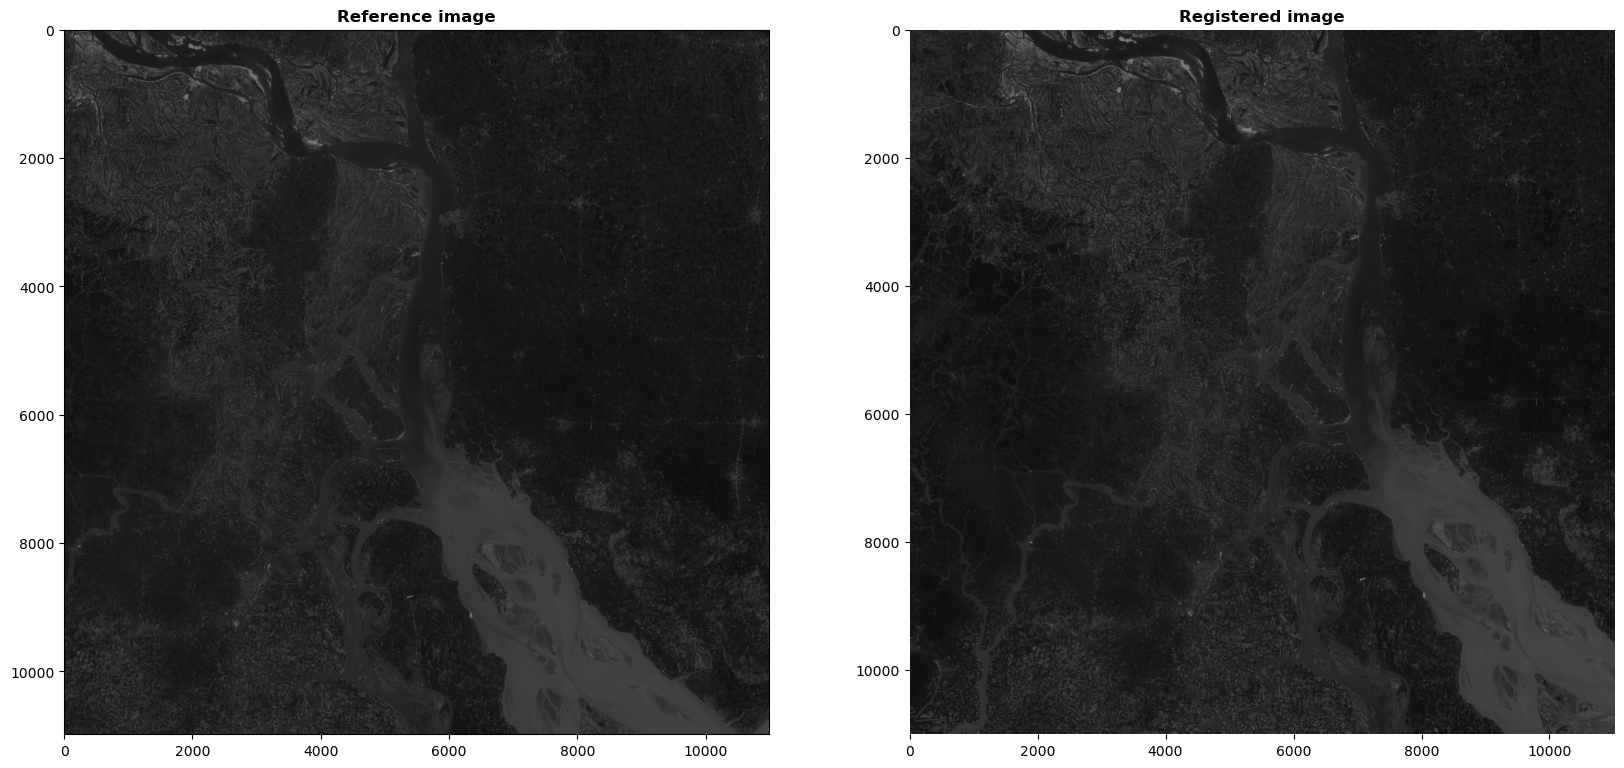

In [8]:
# open and read the files
with rasterio.open(ref_image) as src_ref, rasterio.open(reg_image) as src_tgt:
    reference_img = src_ref.read()
    target_img = src_tgt.read()
    
    # plot the reference and registered images
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))

    rasterio.plot.show(reference_img, ax=ax1, cmap='gray', title="Reference image")

    rasterio.plot.show(target_img, ax=ax2, cmap='gray', title="Registered image")

    plt.box(False)

# 3. Georeferencing

## 3.1 Feature detection using OpenCV
Band 4: It is strongly reflected by dead foliage and is useful for identifying vegetation types, soils and urban (city and town) areas. It has limited water penetration and doesn’t reflect well from live foliage with chlorophyll.
### Candidate Algorithims
1. ORB (used) - Faster since it is binary, requires less computation power and gets key points more efficiently. ORB has additional properties i.e., scale invariance, rotational invariance, illumination invariance and noise invariance 
2. SIFT - Powerful and accurate in image matching but requires more computation power and is patent protected
3. SURF - Powerful and accurate in image matching but patent protected
4. BRIEF - Robust and speeds up computation of descriptors but you need to use separate detector before using it

In [15]:
# Convert the images to grayscale
img1 = cv2.imread(ref_image)
img2 = cv2.imread(reg_image)

# store starting time
begin = time.time()

def orb_detector(image1, image2):
    """Uses ORB algorithim to detect features and Brute Force matcher to match similar 
    features in the reference and registered image 
    
    inputs: registerd image and reference image
    outputs: good matches, matches, keypoints and descriptors"""
   
    # initiate ORB detector
    # nfeatures set to 5000 to increase accuracy of detection
    # edge threshold - size of border where features are not detected
    # fast threshold - Threshold between intensity of a pixel and the pixels surrounding it
    
    orb = cv2.ORB_create(nfeatures = 5000, fastThreshold=2, edgeThreshold=2)

    # find the keypoints and descriptors
    kp1, des1 = orb.detectAndCompute(image1,None)
    kp2, des2 = orb.detectAndCompute(image2,None)
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    # check if object descriptors exist
    if des1 is not None or des2 is not None:
        #create matches
        matches = bf.match(des1,des2)

        # Compute number of good matches 
        good_matches = []
        for match in matches:
            # we take the shortest distances for good results
            if match.distance < 0.75 * min(len(kp1), len(kp2)):
                good_matches.append(match)

        # draw matches.
        img_matches = cv2.drawMatches(img1,kp1,img2,kp2,good_matches[:2000],None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
        cv2.imwrite("matches.png",img_matches)
    else:
        return "Could not find matching objects in the two images"
    return kp1, des1, kp2, des2, good_matches, matches
    
kp1, des1, kp2, des2, good_matches, matches = orb_detector(img1,img2) # function call

time.sleep(1)

# store end time
end = time.time()

processing_time = end - begin

In [32]:
def homography_matrix(image1, image2, keyp1, keyp2, inliers):  
    """ Computes a homography matrix that is then used to georeference the registered image
    
    inputs: products of the orb_detector fuction i.e., registerd and reference images, key points and good matches 
    outputs: coregistered image"""
    
    # obtain height and width of the reference image to be used in registering the target image
    height, width, channels = image1.shape
    
    # calculate the homography matrix
    ref_pts = np.float32([keyp1[m.queryIdx].pt for m in inliers]).reshape(-1, 1, 2)
    
    target_pts = np.float32([keyp2[m.trainIdx].pt for m in inliers]).reshape(-1, 1, 2)

    homography,mask = cv2.findHomography(target_pts, ref_pts, cv2.RANSAC, 5.0)

    # use homography matrix to transform the image
    img_transformed = cv2.warpPerspective(image2, homography, (width, height))
    
    # store the resulting image
    coregistered_image = reg_image.split('/')[-1].replace('.jp2', '_coregistered.jp2')

    coregistered_im_file = f'{georeferenced_path}{os.path.basename(coregistered_image)}'

    cv2.imwrite(coregistered_im_file, img_transformed)
    
    return "The registered image has been successfully coregistered"

homography_matrix(img1, img2, kp1, kp2, good_matches) #function call

'The registered image has been successfully coregistered'

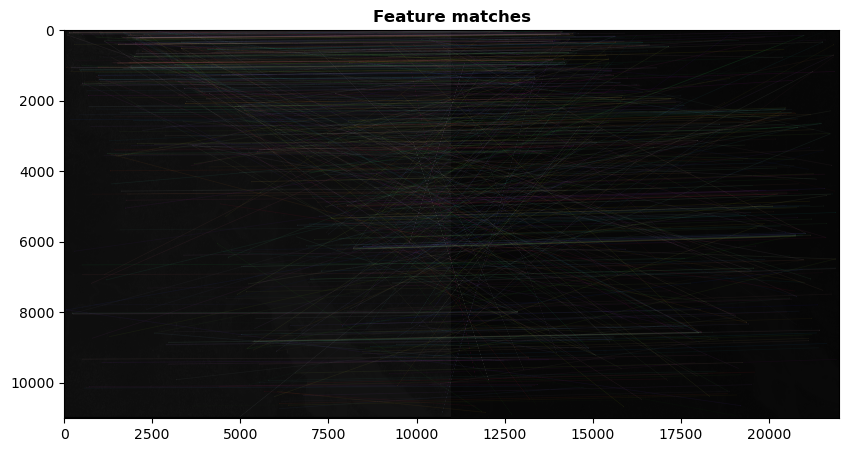

In [31]:
# plot the image with the detected features
with rasterio.open("matches.png") as src_matches:
    
    img_matches = src_matches.read()
    
    # plot the image with the matches 
    
    fig, ax1 = plt.subplots(1, 1, figsize=(10,10))
    
    rasterio.plot.show(img_matches, ax=ax1, cmap='gray', title="Feature matches")

In [33]:
# update the coregistered image with metadata using rasterio
coregistered_image = glob.glob(f'{georeferenced_path}*.jp2')[0]

coregistered_image = wrapped_image.replace('\\','/')

with rasterio.open(coregistered_image, "r+") as src_coregistered, rasterio.open(ref_image) as src_reference :
    wrapped_img= src_coregistered.read(1)
    transform = src_reference.transform
    profile = src_reference.meta.copy()
    profile.update({
        'crs': src_reference.crs,
        'transform': transform
    })

    # Write the data to a new image file
    with rasterio.open(wrapped_image, "w", **profile) as dst:
        dst.write(wrapped_img,1)

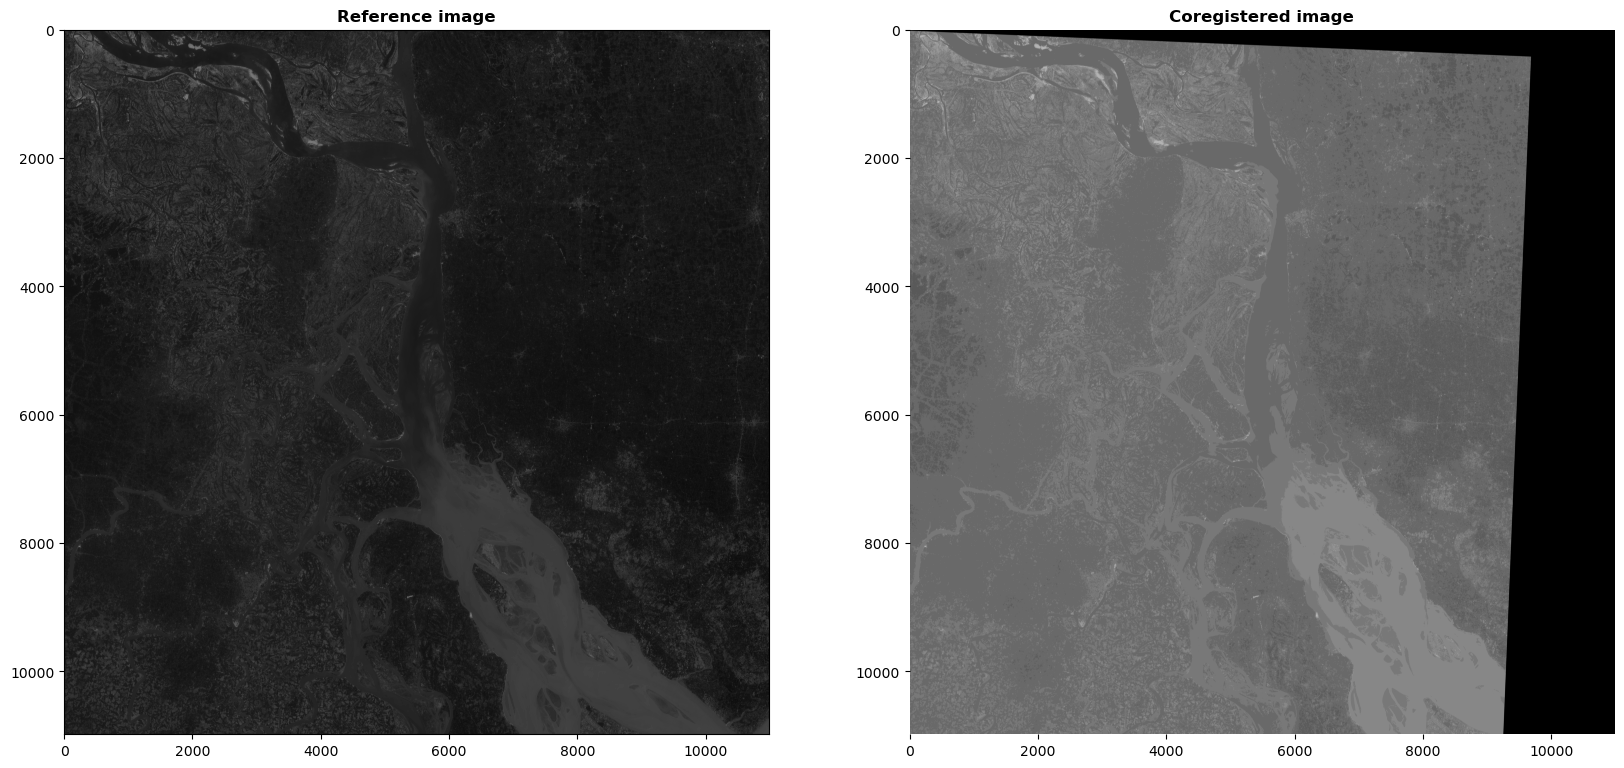

In [34]:
cor_image_georeferenced = glob.glob(f'{georeferenced_path}*.jp2')[0]

cor_image_georeferenced = cor_image_georeferenced.replace('\\','/')

with rasterio.open(cor_image_georeferenced) as src, rasterio.open(ref_image) as src_reference:
    wimg = src.read(1)
    rimg = src_reference.read(1)
    # plot the reference image and coregistered image 
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))

    rasterio.plot.show(rimg, ax=ax1, cmap='gray', title="Reference image")

    rasterio.plot.show(wimg, ax=ax2, cmap='gray', title="Coregistered image")

    plt.box(False)

# 4. ORB algorithm performance evaluation
1. Processing time - Time consumed to complete the feature detection and matching process
2. Number of matching points in both images
3. Good matching ratio (GMR) - Good matches/total matches
4. Matching efficiency - Good matches / Processing time

In [22]:
#calculate good matching ratio
GMR = (len(good_matches) / len(matches)) * 100

#calculate matching efficiency
ME = len(good_matches)/processing_time

# print performances achieved
print(f"Processing time: {processing_time:.2f} seconds")
print(f"Number of matches: {len(matches)}")
print(f"Number of good matches: {len(good_matches)}")
print(f"Number of keypoints detected in the reference image: {len(kp1)} ")
print(f"Number of keypoints detected in the registered image: {len(kp2)}")
print(f"GMR: {GMR}%")
print(f"ME: {ME:.0f} matches/second")

Processing time: 15.32 seconds
Number of matches: 701
Number of good matches: 701
Number of keypoints detected in the reference image: 5000 
Number of keypoints detected in the registered image: 4828
GMR: 100.0%
ME: 46 matches/second


# 5. Performance optimization for multiple images
### Options
1. Principal component analysis (PCA) - applied to each image to select the most important principal components which reduces the dimensionality of feature descriptor and reduce the complexity of the feature point descriptor data and only uses the selected descriptors for image matching. PCA can be accessed through the sklearn library.
2. Image pyramids - An image pyramid is a multiscale representation of a single image, that consist of sequences of images all of which are versions of the image at different resolutions. Each level in the pyramid contains the downsampled version of the image than the previous level. Consequently, image pyramids results into a reduction in the number of descriptors and key points needed for processing. ORB algorithim uses multiscale image pyramid to reduce the computation burden of processing. Alternatively, one can also utilize pyrDown and pyrUp from opencv to implement image pyramids.

### References
1. [Numpy](https://numpy.org/doc/) 
2. [Rasterio](https://rasterio.readthedocs.io/en/latest/topics/reading.html)
3. [OpenCV](https://docs.opencv.org/4.x/) 
4. [GeeksforGeeks](https://www.geeksforgeeks.org/feature-matching-using-orb-algorithm-in-python-opencv/)
5. [Medium](https://medium.com/data-breach/introduction-to-orb-oriented-fast-and-rotated-brief-4220e8ec40cf)
6. [Performance_Comparison_of_Feature_Generation_Algorithms_for_Mosaic_Photoacoustic_Microscopy](https://www.researchgate.net/publication/354198129_Performance_Comparison_of_Feature_Generation_Algorithms_for_Mosaic_Photoacoustic_Microscopy)
7. [Matching and Co-Registration of Satellite Images
Using Local Features](https://icsos2014.nict.go.jp/contents/pdf/P-24.pdf)